# Assignemnt 2


# Loading the dataset, normalizing the imgaes pixel values, and one-hot encoding the labels

In [5]:
import cv2 # Library for dealing with images, the biggest and the fastest, written in cpp, wrapped in python.
import os # Library for dealing wiht the operating system, getting folders, files, and much much more.
import numpy as org_np # Numerical Python, library for doing most of the mathematical operations needed in machine learning.
import cupy as np
import torch
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn


def one_hot_encoding(img_true_classes, num_of_classes):
    num_of_images = img_true_classes.shape[0]
    one_hot_encoded_matrix = np.zeros((num_of_images, num_of_classes))
    one_hot_encoded_matrix[np.arange(num_of_images), img_true_classes] = 1

    return one_hot_encoded_matrix



resnet = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)
resnet_no_output = nn.Sequential(*list(resnet.children())[:-1])

def extract_features(data_dir, model):

    features = []
    labels = []

    classes_names = [entry.name for entry in os.scandir(data_dir) if entry.is_dir()]
    classes_names = sorted(classes_names)

    
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]) # preprocess is a function

    for class_index, class_name in enumerate(classes_names):
        class_path = os.path.join(data_dir,class_name)
        print(f"Loading Class {class_index}: {class_name}")


        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            
            try:
                img_np_arr = cv2.imread(img_path)

                if img_np_arr is None:
                    continue

                img_rgb = cv2.cvtColor(img_np_arr, cv2.COLOR_BGR2RGB)
                img_t = preprocess(img_rgb)
                input_batch = img_t.unsqueeze(0)

                with torch.no_grad():
                    output_tensor = model(input_batch)
                    feature_vector = output_tensor.flatten().cpu().numpy()
                
                features.append(feature_vector)
                labels.append(class_index)

            except Exception as e:
                print(f"Error loading {img_name}: {e}")
                
    return org_np.array(features), org_np.array(labels), classes_names
    

In [6]:
# import cv2 # Library for dealing with images, the biggest and the fastest, written in cpp, wrapped in python.
# import os # Library for dealing wiht the operating system, getting folders, files, and much much more.
# import numpy as org_np # Numerical Python, library for doing most of the mathematical operations needed in machine learning.
# import cupy as np # NumPy, but runs on the GPU.
# import matplotlib.pyplot as plt



# def one_hot_encoding(img_true_classes, num_of_classes):
#     num_of_images = img_true_classes.shape[0]
#     one_hot_encoded_matrix = np.zeros((num_of_images, num_of_classes))
#     one_hot_encoded_matrix[np.arange(num_of_images), img_true_classes] = 1

#     return one_hot_encoded_matrix

# def load_dataset(data_dir, img_size = 64):
#     features = []
#     labels = []

#     classes_names = [entry.name for entry in os.scandir(data_dir) if entry.is_dir()]
#     classes_names = sorted(classes_names)

#     for class_index, class_name in enumerate(classes_names):
#         class_path = os.path.join(data_dir,class_name)
#         print(f"Loading Class {class_index}: {class_name}")

#         for img_name in os.listdir(class_path):
#             img_path = os.path.join(class_path, img_name)
            
#             try:
#                 img_np_arr = cv2.imread(img_path)

#                 if img_np_arr is None:
#                     continue
                
#                 img_resized_arr = cv2.resize(img_np_arr, (img_size,img_size))
#                 img_flatten_arr = img_resized_arr.flatten()
#                 features.append(img_flatten_arr)
#                 labels.append(class_index)

#             except Exception as e:
#                 print(f"Error loading {img_name}: {e}")


#     X = np.array(features)
#     y = np.array(labels)

#     X = X/255
#     y = one_hot_encoding(y, len(classes_names))

#     return X, y, classes_names

# Data Spliting

In [7]:
# def split_data(X, y, train_ratio = 0.7, v_ratio = 0.15, test_ratio = 0.15):
#     num_of_imgs = X.shape[0]
#     indices = np.random.permutation(num_of_imgs)
#     train_index = int(train_ratio * num_of_imgs)
#     v_index = int(v_ratio * num_of_imgs)
#     test_index = int(test_ratio * num_of_imgs) # just for indication, not really needed

#     train_idx = indices[:train_index]
#     v_idx = indices[train_index: train_index + v_index]
#     test_idx = indices[train_index + v_index:]

#     X_train, X_validation, X_test = X[train_idx], X[v_idx], X[test_idx]
#     y_train, y_validation, y_test = y[train_idx], y[v_idx], y[test_idx]

#     return X_train, X_validation, X_test, y_train, y_validation, y_test

In [8]:
from sklearn.model_selection import train_test_split
features, labels, classes_names = extract_features(r"C:\Life\FCAI_Stuff\Third_year_AI\Intro_to_ML\Assignments\Sea_Animals",resnet_no_output)

# split to (train + validate) and (test)
x_train_validate, x_test, y_train_validate, y_test = train_test_split(
    features,
    labels,
    test_size = 0.15,
    stratify = labels,
    random_state =42
) 
# split x/y(train_validate) into train and validate
x_train, x_validate, y_train, y_validate = train_test_split(
    x_train_validate,
    y_train_validate,
    test_size = 0.15,
    stratify = y_train_validate,
    random_state = 42
)

y_train = one_hot_encoding(org_np.asarray(y_train), len(classes_names))
y_test = one_hot_encoding(org_np.asarray(y_test), len(classes_names))
y_validate = one_hot_encoding(org_np.asarray(y_validate), len(classes_names))


x_train = np.asarray(x_train, dtype = np.float32)
x_test = np.asarray(x_test, dtype = np.float32)
x_validate = np.asarray(x_validate, dtype = np.float32)

y_train = np.asarray(y_train, dtype = np.float32)
y_test = np.asarray(y_test, dtype = np.float32)
y_validate = np.asarray(y_validate, dtype = np.float32)



Loading Class 0: Clams
Loading Class 1: Corals
Loading Class 2: Crabs
Loading Class 3: Dolphin
Loading Class 4: Eel
Loading Class 5: Fish
Loading Class 6: Jelly_Fish
Loading Class 7: Lobster
Loading Class 8: Nudibranchs
Loading Class 9: Octopus
Loading Class 10: Otter
Loading Class 11: Penguin
Loading Class 12: Puffers
Loading Class 13: Sea_Rays
Loading Class 14: Sea_Urchins
Loading Class 15: Seahorse
Loading Class 16: Seal
Loading Class 17: Sharks
Loading Class 18: Shrimp
Loading Class 19: Squid
Loading Class 20: Starfish
Loading Class 21: Turtle_Tortoise
Loading Class 22: Whale


# Choosing the number of hidden layers, and the activation function for the hidden layers

In [9]:
def build_nueral_network(in_size, out_size):
    hid_layers_num = int(input("So, how many hidden layers do you need for your MLP ?\nNumber of hidden layers: "))
    hid_sizes = []

    for i in range(hid_layers_num):
        hid_layer_size = int(input(f"Please enter the number of nuerons that you need in layer number {i + 1}: "))
        hid_sizes.append(hid_layer_size)

    activ_func = int(input("""
                           Lastly, what is the Activation function you want to use in the hidden layers?
                           1) Sigmoid
                           2) Relu
                           Choose (1/2): 
                           """))

    net_sizes = in_size + hid_sizes + out_size
    return net_sizes , activ_func

# Intializing the first weights and biases

In [ ]:
def intialize_param(net_sizes):        
    weights = []
    biases = []

    for i in range(len(net_sizes) - 1):
        input_dim = net_sizes[i] 
        output_dim =  net_sizes[i + 1]


        # He initialization for ReLU: scale by sqrt(2/input_dim)
        # This prevents vanishing/exploding gradients with ReLU
        weight = np.random.randn(output_dim, input_dim) * np.sqrt(2.0 / input_dim)
        weights.append(weight)
        bias = np.zeros((output_dim, 1))
        biases.append(bias)

    return weights, biases

# Activation functions

In [11]:
def Sigmoid(z):
    return 1 / (1 + np.exp(-z))

def Relu(z):
    return np.maximum(0, z)

def SoftMax(z):
    # 1. Numerical Stability Trick
    # If Z contains large numbers wil cause an overflow error.
    # By subtracting the max value from every column, the largest number becomes 0.
    # e^0 = 1, which is safe. The math result remains identical.
    # axis=0 means "find max down the column" (for each image separately).
    # keepdims = true => keeps the values that we divide the matrix by in a proper shape to do so (as in vecotr not elements)

    # SoftMax = e^z/sum(e^z)
    shift_z = z - np.max(z, axis=0, keepdims=True)
    exp_z = np.exp(shift_z)
    sum_exp_z = np.sum(exp_z, axis=0, keepdims= True)

    A = exp_z / sum_exp_z

    return A

# Forward propagation

In [12]:
def forward_propagation(X, weights, biases, activ_func):

    A = X.T # input for each layer initialized with the input layer

    # to save the values of A(inputs to the layer) and Z(Netj) for the backward propagation
    # Why save Z? simply because we use its derivative in the backword path
    cache_A = []
    cache_Z = []
    cache_A.append(A)

    # enumerate gives automatic counter inside loop without the need to manually increment
    # it returns [index, tubel(weights, biases)]
    for layer_index, (w,b) in enumerate(zip(weights, biases)):
        Z = np.dot(w,A) + b # Netj = Z = wx + b
        cache_Z.append(Z)

        if layer_index == len(weights) - 1: # if it is the ouput layer
            A = SoftMax(Z)
            cache_A.append(A)
        else:
            if activ_func == 1: # hidden with Sigmoid as an activation function
                A = Sigmoid(Z)
                cache_A.append(A)
            elif activ_func == 2: # hidden with Relu as an acitivation function
                A = Relu(Z)
                cache_A.append(A)
    
    return cache_A, cache_Z

# Backward propagation

In [13]:
def sigmoid_derivative(z):
    sig = Sigmoid(z)
    return sig * (1 - sig)

def relu_derivative(z):
    return (z > 0).astype(float)

def backward_propagation(cache_A, cache_Z, weights, y, activ_func, m):
    num_layers = len(weights)
    weight_gradients = []
    bias_gradients = []

    # dA = Predictions - True Labels
    dA = cache_A[-1] - y.T

    # Backpropagate through each layer (from last to first)
    for layer_index in range(num_layers - 1, -1, -1):
        # Get Z and A for this layer
        Z_curr = cache_Z[layer_index]
        A_prev = cache_A[layer_index]
        W_curr = weights[layer_index]

        # Calculate dZ (derivative with respect to Z)
        if layer_index == num_layers - 1:
            dZ = dA
        else:
            # Hidden layers: dZ = dA * activation_derivative(Z)
            if activ_func == 1:  # Sigmoid
                dZ = dA * sigmoid_derivative(Z_curr)
            elif activ_func == 2:  # ReLU
                dZ = dA * relu_derivative(Z_curr)
        
        # Calculate dW (gradient for weights)
        # dW = (1/m) * dZ * A_prev.T
        dW = (1/m) * np.dot(dZ, A_prev.T)
        weight_gradients.insert(0, dW)
        
        # Calculate db (gradient for biases)
        # db = (1/m) * sum of dZ along all samples
        db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        bias_gradients.insert(0, db)
        
        # Calculate dA for next iteration (previous layer)
        # dA_prev = W.T * dZ
        if layer_index > 0:
            dA = np.dot(W_curr.T, dZ)
    
    return weight_gradients, bias_gradients

# Loss Function

In [14]:
def calculate_loss(predictions, y_true, m):
    # Add small epsilon to avoid log(0)
    epsilon = 1e-15
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    
    # Cross-entropy for multi-class classification
    # y_true.T is (num_classes, m), predictions is (num_classes, m)
    # We multiply element-wise and sum
    loss = -(1/m) * np.sum(y_true.T * np.log(predictions))
    
    return loss

# Update Parameters (Gradient Descent)

In [15]:
def update_parameters(weights, biases, weight_gradients, bias_gradients, learning_rate):
    updated_weights = []
    updated_biases = []
    
    for i in range(len(weights)):
        # Update weights: W = W - learning_rate * dW
        updated_W = weights[i] - learning_rate * weight_gradients[i]
        updated_weights.append(updated_W)
        
        # Update biases: b = b - learning_rate * db
        updated_b = biases[i] - learning_rate * bias_gradients[i]
        updated_biases.append(updated_b)
    
    return updated_weights, updated_biases

# Actual Training

In [16]:
def calc_acc(X, y_true_one_hot, weights, biases, activ_func):
    a_cache, _ = forward_propagation(X, weights, biases, activ_func)
    probabilities = a_cache[-1]

    predictions = np.argmax(probabilities, axis = 0)
    true_labels = np.argmax(y_true_one_hot, axis = 1)

    acc = np.mean(predictions == true_labels)
    return acc * 100


def train(X_train, y_train, X_test, y_test, net_sizes, activ_func, epochs = 1000, learning_rate = 0.01):

    num_of_training_imgs = X_train.shape[0]
    weights, biases = intialize_param(net_sizes)

    loss_history = []
    train_acc_history = []
    test_acc_history = []

    print(f"Training on GPU for {epochs} epochs...")

    for i in range(epochs):
        a_cache, z_cache = forward_propagation(X_train,weights,biases,activ_func)
        weight_grads, bias_grads = backward_propagation(a_cache, z_cache, weights, y_train, activ_func, num_of_training_imgs)       
        updated_weights, updated_biases = update_parameters(weights, biases, weight_grads, bias_grads, learning_rate)
        weights, biases = updated_weights, updated_biases


        if i % 100 == 0:
            current_loss = calculate_loss(a_cache[-1], y_train, num_of_training_imgs)
            train_acc = calc_acc(X_train, y_train, weights, biases, activ_func)
            test_acc = calc_acc(X_test, y_test, weights, biases, activ_func)

            loss_history.append(current_loss)
            train_acc_history.append(train_acc)
            test_acc_history.append(test_acc)
            print(f"Epoch {i}: Loss {current_loss: .4f} | Train Acc: {train_acc: .1f}% | Test Acc: {test_acc: .1f}%")

    return weights, biases, loss_history, train_acc_history, test_acc_history

# Prediction Function

In [17]:
def predict(X_test, y_test, weights, biases,activ_func, classes_names):
    a_cache, _ = forward_propagation(X_test, weights, biases, activ_func)
    probabilities_of_output_class = a_cache[-1]
    predicted_indices_gpu = np.argmax(probabilities_of_output_class, axis = 0)
    true_indices_gpu = np.argmax(y_test, axis = 1)
    predicted_indices_cpu = predicted_indices_gpu.get()
    true_indices_cpu = true_indices_gpu.get()

    predicted_names = org_np.array(classes_names)[predicted_indices_cpu]
    true_names = org_np.array(classes_names)[true_indices_cpu]

    return predicted_names, true_names


In [23]:
import matplotlib.pyplot as plt

def plot_results(loss_history, train_acc_history, val_acc_history):
    """
    Plot training results: loss and accuracy curves.
    
    Parameters:
    -----------
    loss_history : list
        Training loss values recorded at intervals
    train_acc_history : list
        Training accuracy values recorded at intervals
    val_acc_history : list
        Validation/test accuracy values recorded at intervals
    """
    # Convert CuPy arrays to NumPy arrays if needed
    if hasattr(loss_history[0], 'get'):  # Check if CuPy array
        loss_cpu = [float(loss.get()) for loss in loss_history]
        train_acc_cpu = [float(acc.get()) for acc in train_acc_history]
        val_acc_cpu = [float(acc.get()) for acc in val_acc_history]
    else:
        loss_cpu = [float(loss) for loss in loss_history]
        train_acc_cpu = [float(acc) for acc in train_acc_history]
        val_acc_cpu = [float(acc) for acc in val_acc_history]
    
    # Create epochs array (x-axis) - assuming checkpoints every 100 epochs
    epochs = org_np.arange(0, len(loss_history) * 100, 100)
    
    # Create figure with 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Training Loss
    ax1.plot(epochs, loss_cpu, 'b-', linewidth=2, label='Training Loss')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    
    # Plot 2: Training and Validation Accuracy
    ax2.plot(epochs, train_acc_cpu, 'g-', linewidth=2, label='Training Accuracy')
    ax2.plot(epochs, val_acc_cpu, 'r-', linewidth=2, label='Validation Accuracy')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print final results
    print(f"\n{'='*50}")
    print(f"Final Training Results:")
    print(f"{'='*50}")
    print(f"Final Loss: {loss_cpu[-1]:.4f}")
    print(f"Final Training Accuracy: {train_acc_cpu[-1]:.2f}%")
    print(f"Final Validation Accuracy: {val_acc_cpu[-1]:.2f}%")
    print(f"{'='*50}\n")

# Plotting Results Function

# Running the model

In [ ]:
# UPDATED: Use extracted features with proper normalization
# Default hyperparameters for fair comparison with PyTorch models

# Normalize features: standardization (mean=0, std=1)
print("=== Normalizing Features ===")
x_train_mean = x_train.mean(axis=0, keepdims=True)
x_train_std = x_train.std(axis=0, keepdims=True) + 1e-8  # avoid division by zero

x_train_normalized = (x_train - x_train_mean) / x_train_std
x_test_normalized = (x_test - x_train_mean) / x_train_std  # use train stats
x_validate_normalized = (x_validate - x_train_mean) / x_train_std

print(f"Original feature range: [{float(x_train.min()):.2f}, {float(x_train.max()):.2f}]")
print(f"Normalized feature range: [{float(x_train_normalized.min()):.2f}, {float(x_train_normalized.max()):.2f}]")

input_layer_size = [x_train.shape[1]]  # 512-d features from ResNet18
output_layer_size = [len(classes_names)]  # 23 classes

# Set comparable defaults: 2 hidden layers [256, 128], ReLU activation
net_sizes = input_layer_size + [256, 128] + output_layer_size
activ_func = 2  # ReLU (to match PyTorch baseline)

print(f"\n=== From-Scratch MLP Configuration ===")
print(f"Network architecture: {net_sizes}")
print(f"Activation: {'ReLU' if activ_func == 2 else 'Sigmoid'}")
print(f"Input features: {input_layer_size[0]}")
print(f"Output classes: {output_layer_size[0]}")

print("\n=== Starting Training on GPU ===")
trained_weights, trained_biases, loss_hist, train_acc_hist, test_acc_hist = train(
    x_train_normalized, y_train, x_test_normalized, y_test, 
    net_sizes, activ_func, 
    epochs=3000,  # More epochs for convergence
    learning_rate=0.01  # Balanced learning rate
)

print("\n=== Plotting Training Results ===")
# Plot loss and accuracy curves
plot_results(loss_hist, train_acc_hist, test_acc_hist)

print("\n=== Running Prediction on Test Set ===")
pred_names, true_names = predict(x_test_normalized, y_test, trained_weights, trained_biases, activ_func, classes_names)

print("\n=== Test Results ===")
correct_count = 0
total_count = len(pred_names)

for i in range(total_count):
    if pred_names[i] == true_names[i]:
        correct_count += 1

# Final Accuracy
from_scratch_test_acc = (correct_count / total_count) * 100
print(f"\n=== From-Scratch MLP Test Accuracy: {from_scratch_test_acc:.2f}% ===")
print(f"Correct predictions: {correct_count}/{total_count}")

=== Normalizing Features ===
Original feature range: [0.61, 1.57]
Normalized feature range: [-6.76, 5.17]

=== From-Scratch MLP Configuration ===
Network architecture: [512, 256, 128, 23]
Activation: ReLU
Input features: 512
Output classes: 23

=== Starting Training on GPU ===
Training on GPU for 3000 epochs...
Epoch 0: Loss  3.1356 | Train Acc:  4.6% | Test Acc:  3.7%
Epoch 100: Loss  3.1252 | Train Acc:  13.9% | Test Acc:  13.9%
Epoch 200: Loss  3.1157 | Train Acc:  13.9% | Test Acc:  13.9%
Epoch 300: Loss  3.1071 | Train Acc:  13.9% | Test Acc:  13.9%
Epoch 400: Loss  3.0994 | Train Acc:  13.9% | Test Acc:  13.9%
Epoch 500: Loss  3.0925 | Train Acc:  13.9% | Test Acc:  13.9%
Epoch 600: Loss  3.0863 | Train Acc:  13.9% | Test Acc:  13.9%
Epoch 700: Loss  3.0809 | Train Acc:  13.9% | Test Acc:  13.9%
Epoch 800: Loss  3.0761 | Train Acc:  13.9% | Test Acc:  13.9%
Epoch 900: Loss  3.0719 | Train Acc:  13.9% | Test Acc:  13.9%
Epoch 1000: Loss  3.0682 | Train Acc:  13.9% | Test Acc:  13.

=== Plotting Training Results ===


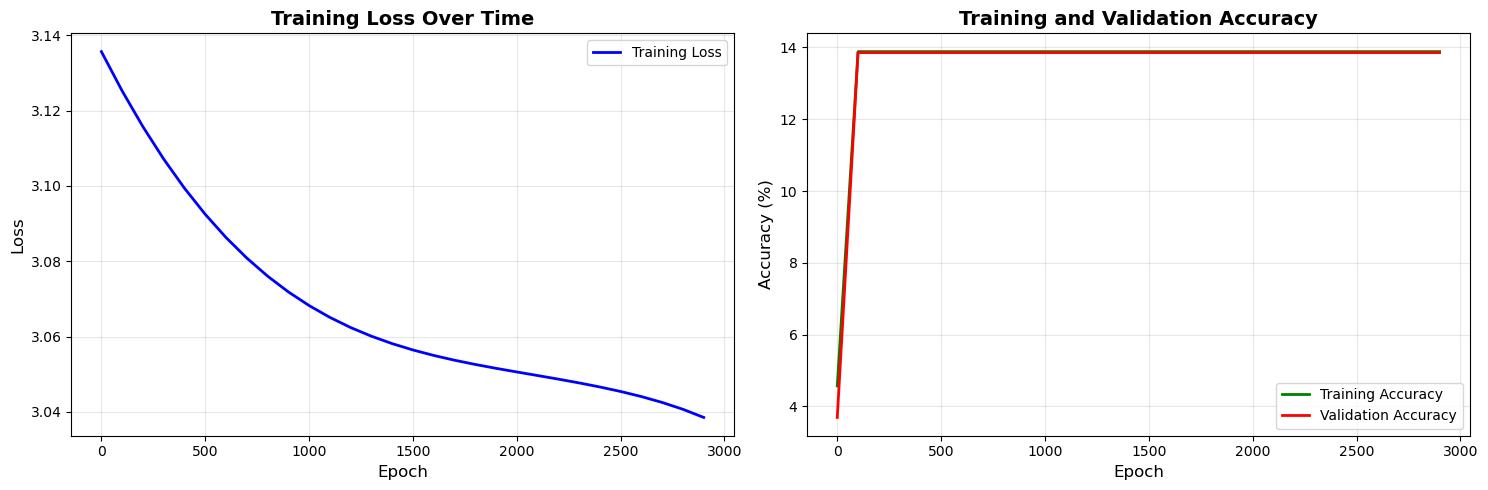


Final Training Results:
Final Loss: 3.0385
Final Training Accuracy: 13.88%
Final Validation Accuracy: 13.86%



In [24]:
# Plot the training results from the previous training run
print("=== Plotting Training Results ===")
plot_results(loss_hist, train_acc_hist, test_acc_hist)

# Visualize Training Results

# Transfer From-Scratch Results to PyTorch Notebook

Now copy the test accuracy value and paste it into the PyTorch notebook for the final comparison report.